# Forest for the Trees 
### Predicting Tree Types from the NYC Tree Survey Using Random Forest

Dataset can be found [here](https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh) on NYC Open Data (data dictionary included)

Published on [Brunchline](www.brunchline.co) by [@DQOfficial](github.com/DQOfficial)

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
import sys
print sys.version
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc

Populating the interactive namespace from numpy and matplotlib
2.7.11 (default, Dec  5 2015, 14:44:47) 
[GCC 4.2.1 Compatible Apple LLVM 7.0.0 (clang-700.1.76)]


`%matplotlib` prevents importing * from pylab and numpy


In [27]:
# read in the data from NYC Open Data
df = pd.read_json('https://data.cityofnewyork.us/resource/nwxe-4ae8.json')

In [28]:
print df.columns
print ''
print 'we have %d columns' % len(df.columns)
print 'and we have %d types of trees' % len(df.spc_common.unique())

Index([u'address', u'block_id', u'boro_ct', u'borocode', u'boroname',
       u'brch_light', u'brch_other', u'brch_shoe', u'cb_num', u'cncldist',
       u'created_at', u'curb_loc', u'fid', u'guards', u'health', u'latitude',
       u'longitude', u'nta', u'nta_name', u'root_grate', u'root_other',
       u'root_stone', u'sidewalk', u'spc_common', u'spc_latin', u'st_assem',
       u'st_senate', u'state', u'status', u'steward', u'stump_diam',
       u'tree_dbh', u'tree_id', u'trnk_light', u'trnk_other', u'trunk_wire',
       u'user_type', u'x_sp', u'y_sp', u'zip_city', u'zipcode'],
      dtype='object')

we have 41 columns
and we have 63 types of trees


In [4]:
# create new dataframe with only the columns we'd like
data = df[['block_id','zipcode','borocode','brch_light','cncldist',
           'brch_other','brch_shoe', 'tree_dbh','stump_diam','spc_common']]

In [5]:
# which trees are the most common?
trees_df = pd.DataFrame({'count':data.spc_common.value_counts()})
trees_df.reset_index(inplace=True)
trees_df.columns=['name','count']
trees_df[:3]

,name,count
0,Pin Oak,162
1,London Planetree,110
2,Callery Pear,102


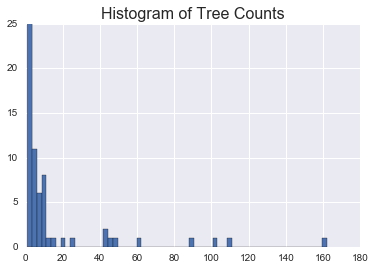

In [6]:
# what does the distribution of tree types look like?
#trees_df['count'].hist(bins=len(df.spc_common.unique()))
plt.hist(trees_df['count'], bins=len(df.spc_common.unique()))
plt.title('Histogram of Tree Counts', fontsize =16)

In [7]:
# create a binary flag variable for pin oak trees, since we don't want to measure it across all different types
data['pin_oak_flag'] = np.where(data['spc_common']=='Pin Oak',1,0)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [8]:
# then convert categorical data to numeric since random forest doesn't like categorical data
def convert(data):
    num = preprocessing.LabelEncoder()
    for i in data.columns:
        data[i] = num.fit_transform(data[i])
        
    return data
    
data = convert(data)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
# split data set into train and test for both our target and predictor variables
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test=train_test_split(data.ix[:,0:9],data['pin_oak_flag'],test_size=0.3, random_state=0)

In [10]:
# train the random forest classifier
clf = RandomForestClassifier(n_estimators=1000)
clf = clf.fit(X_train,y_train)

In [11]:
# calculate model accuracy for both train and test sets
pred = clf.predict(X_train)
print 'The accuracy for the training set is:',1.0*sum(y_train==pred)/len(pred)
pred = clf.predict(X_test)
print 'The accuracy for the test set is:', 1.0*sum(y_test==pred)/len(pred)

The accuracy for the training set is: 0.992857142857
The accuracy for the test set is: 0.913333333333


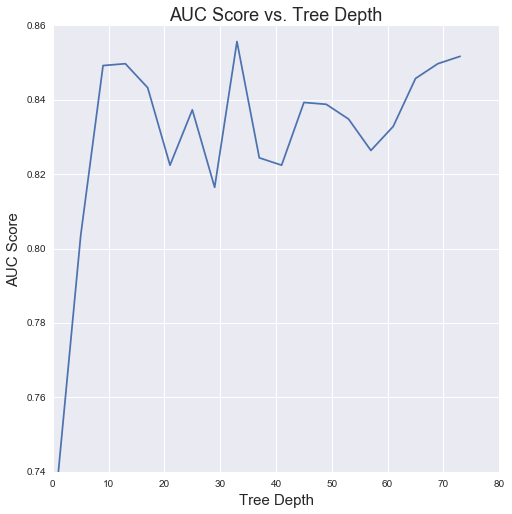

In [12]:
# let's plot the AUC score vs the tree depth
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_auc_score


points = []

d = range(1,75,4)
for i in d:
    clf = DecisionTreeClassifier(max_depth=i)
    clf = clf.fit(X_train, y_train)
    points.append(roc_auc_score(y_test, clf.predict(X_test)))
    
figure, ax = plt.subplots(figsize=(8,8))
ax.plot(d,points)
ax.set_xlabel('Tree Depth', fontsize = 15)
ax.set_ylabel('AUC Score', fontsize = 15)
ax.set_title('AUC Score vs. Tree Depth',fontsize = 18)